In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
import csv
import os
import time

In [5]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloader
def get_data_loaders(train_dir, val_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# model
# baseline
class Baseline(nn.Module):
    def __init__(self, num_classes=5):
        super(Baseline, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False  # freeze
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)



class Model(nn.Module):
    def __init__(self, num_classes=5):
        super(Model, self).__init__()
        
        # Use ResNet50 
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# train
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, warmup_steps=0, output_dir="./output"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.best_model_wts = copy.deepcopy(model.state_dict())
        self.best_accuracy = 0.0
        self.patience = patience
        self.warmup_steps = warmup_steps
        self.early_stop = False
        self.counter = 0
        self.best_score = None

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []  
        self.val_accuracies = []

        self.output_dir = output_dir  #output csv dir
        os.makedirs(self.output_dir, exist_ok=True)

    def train(self, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0  
            total = 0

            for step, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # warm-up steps
                if step < self.warmup_steps:
                    lr_scale = min(1.0, float(step + 1) / self.warmup_steps)
                    for pg in self.optimizer.param_groups:
                        pg['lr'] = lr_scale * self.optimizer.defaults['lr']

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct / total  
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)  
            val_loss, val_accuracy = self.validate()
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

            # early stopping
            self._early_stopping(val_loss)
            if self.early_stop:
                print("Early stopping triggered")
                break

            if val_accuracy > self.best_accuracy:
                self.best_accuracy = val_accuracy
                self.best_model_wts = copy.deepcopy(self.model.state_dict())

        self.model.load_state_dict(self.best_model_wts)
        self.plot_metrics()
        return self.model

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return val_loss / len(self.val_loader), accuracy

    def _early_stopping(self, val_loss):
        score = -val_loss
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
    
    def plot_metrics(self):
        """plot loss and acc curve"""
        epochs = range(1, len(self.train_losses) + 1)

        # loss
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

        # acc
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy', color='blue')  
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy', color='orange')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid()
        plt.show()

    def save_metrics_to_csv(self, csv_filename="training_metrics.csv"):
        """save training history to csv file"""
        csv_path = os.path.join(self.output_dir, csv_filename)
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])
            for epoch in range(len(self.train_losses)):
                writer.writerow([
                    epoch + 1,
                    self.train_losses[epoch],
                    self.train_accuracies[epoch],
                    self.val_losses[epoch],
                    self.val_accuracies[epoch]
                ])
        print(f"Metrics saved to {csv_path}")

In [3]:
print("GPU is available:", torch.cuda.is_available())

GPU is available: True


c:\anaconda\envs\1517\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda\envs\1517\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 1.1452, Train Accuracy: 61.80%, Val Loss: 0.8877, Val Accuracy: 74.37%
Epoch 2/20, Train Loss: 0.8146, Train Accuracy: 72.74%, Val Loss: 0.6919, Val Accuracy: 77.21%
Epoch 3/20, Train Loss: 0.7205, Train Accuracy: 74.87%, Val Loss: 0.7056, Val Accuracy: 78.91%
EarlyStopping counter: 1 out of 5
Epoch 4/20, Train Loss: 0.6703, Train Accuracy: 76.11%, Val Loss: 0.6254, Val Accuracy: 79.91%
Epoch 5/20, Train Loss: 0.6410, Train Accuracy: 76.79%, Val Loss: 0.6068, Val Accuracy: 80.71%
Epoch 6/20, Train Loss: 0.6189, Train Accuracy: 77.64%, Val Loss: 0.6618, Val Accuracy: 81.12%
EarlyStopping counter: 1 out of 5
Epoch 7/20, Train Loss: 0.6036, Train Accuracy: 78.05%, Val Loss: 0.5622, Val Accuracy: 81.75%
Epoch 8/20, Train Loss: 0.5925, Train Accuracy: 78.21%, Val Loss: 0.5737, Val Accuracy: 82.01%
EarlyStopping counter: 1 out of 5
Epoch 9/20, Train Loss: 0.5816, Train Accuracy: 78.51%, Val Loss: 0.5687, Val Accuracy: 82.46%
EarlyStopping counter: 2 out of 5
Epoch 10/

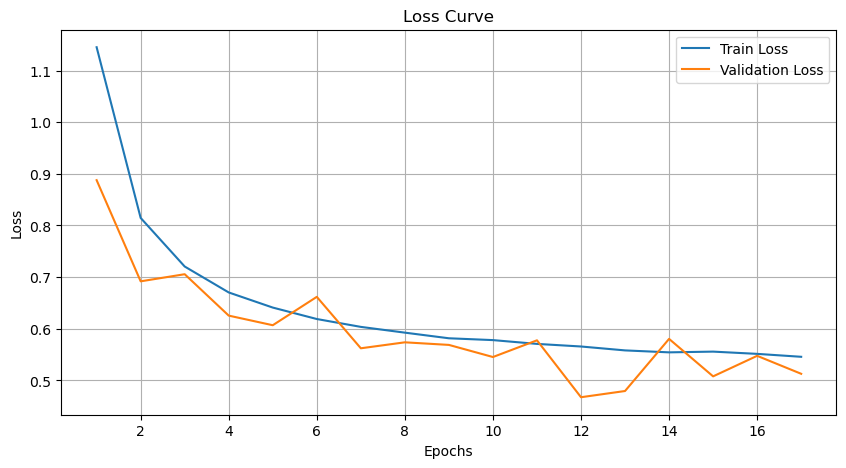

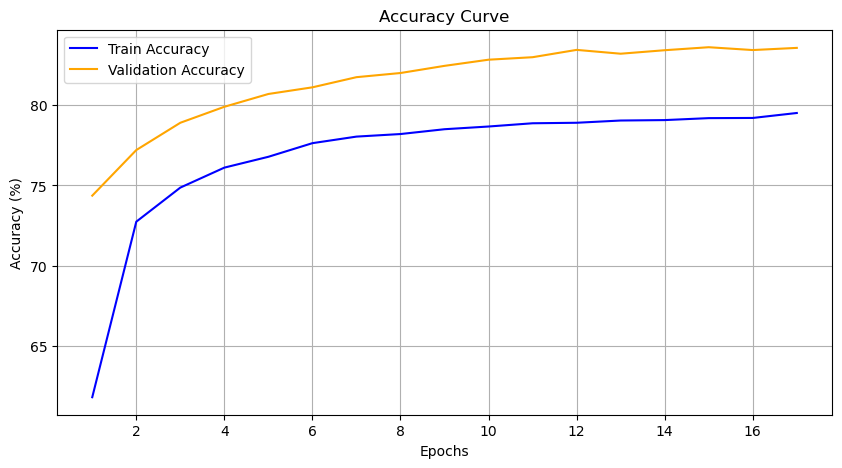

Metrics saved to ./output\baseline_2024-11-24_00-44-58.csv


C:\Users\93757\AppData\Local\Temp\ipykernel_21552\3258613406.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_base.load_state_dict(torch.load(pth_name))


Baseline(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activa

In [4]:
# setup
date= time.strftime("%Y-%m-%d_%H-%M-%S")
train_loader, val_loader = get_data_loaders('C:/uoft/1517/project/project/Streamlit/outputs/Gold/train', 'C:/uoft/1517/project/project/Streamlit/outputs/Gold/val')
model = Baseline(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)

# train model
trainerBase = Trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, warmup_steps=100)

#print out first five pictures of train_loader
trained_model_base = trainerBase.train(num_epochs=20)

# save model checkpoint
pth_name = f"baseline_{date}.pth"
torch.save(trained_model_base.state_dict(), pth_name)

# save training history
csv_filename = f"baseline_{date}.csv"
trainerBase.save_metrics_to_csv(csv_filename)

# load model
trained_model_base.load_state_dict(torch.load(pth_name))
trained_model_base.eval()


c:\anaconda\envs\1517\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.3024, Train Accuracy: 88.44%, Val Loss: 0.6565, Val Accuracy: 78.76%
Epoch 2/20, Train Loss: 0.1420, Train Accuracy: 94.69%, Val Loss: 0.1755, Val Accuracy: 93.38%
Epoch 3/20, Train Loss: 0.0902, Train Accuracy: 96.80%, Val Loss: 0.1488, Val Accuracy: 95.05%
Epoch 4/20, Train Loss: 0.0581, Train Accuracy: 97.95%, Val Loss: 0.1810, Val Accuracy: 94.24%
EarlyStopping counter: 1 out of 5
Epoch 5/20, Train Loss: 0.0505, Train Accuracy: 98.20%, Val Loss: 0.1812, Val Accuracy: 94.47%
EarlyStopping counter: 2 out of 5
Epoch 6/20, Train Loss: 0.0364, Train Accuracy: 98.75%, Val Loss: 0.2144, Val Accuracy: 93.88%
EarlyStopping counter: 3 out of 5
Epoch 7/20, Train Loss: 0.0334, Train Accuracy: 98.90%, Val Loss: 0.2060, Val Accuracy: 93.84%
EarlyStopping counter: 4 out of 5
Epoch 8/20, Train Loss: 0.0262, Train Accuracy: 99.11%, Val Loss: 0.2270, Val Accuracy: 93.39%
EarlyStopping counter: 5 out of 5
Early stopping triggered


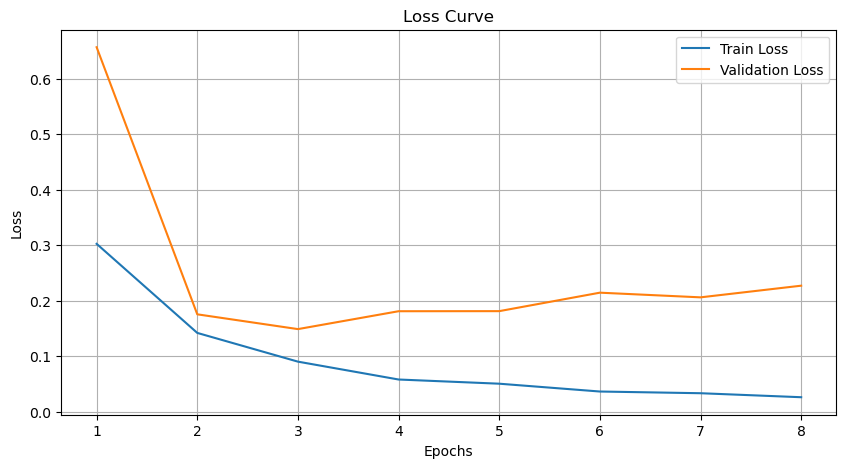

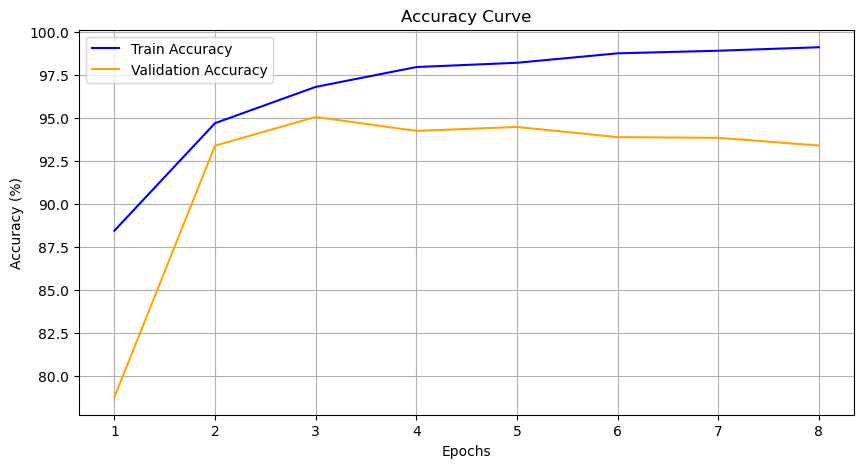

Metrics saved to ./output\resnet_2024-11-24_00-44-58.csv


C:\Users\93757\AppData\Local\Temp\ipykernel_21552\4177881650.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_res.load_state_dict(torch.load(pth_name))


Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [5]:
# setup
train_loader, val_loader = get_data_loaders('C:/uoft/1517/project/project/Streamlit/outputs/Gold/train', 'C:/uoft/1517/project/project/Streamlit/outputs/Gold/val')
model = Model(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)

# train model
trainerRes = Trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, warmup_steps=100)

#print out first five pictures of train_loader
trained_model_res = trainerRes.train(num_epochs=20)

# save model checkpoint
pth_name = f"resnet_{date}.pth"
torch.save(trained_model_res.state_dict(), pth_name)

# save training history
csv_filename = f"resnet_{date}.csv"
trainerRes.save_metrics_to_csv(csv_filename)

# load model
trained_model_res.load_state_dict(torch.load(pth_name))
trained_model_res.eval()



In [8]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    epoch=0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch+=1
    accuracy = 100 * correct / total
    test_loss /= len(test_loader)
    
    return test_loss, accuracy

def get_test_loader(test_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader

In [6]:
trained_model_res= Model(num_classes=5).to(device)
trained_model_res.load_state_dict(torch.load('C:/uoft/1517/project/project/Streamlit/outputs/ckpts/resnet_2024-11-24_00-44-58.pth'))
trained_model_res.eval()

trained_model_base= Baseline(num_classes=5).to(device)
trained_model_base.load_state_dict(torch.load('C:/uoft/1517/project/project/Streamlit/outputs/ckpts/baseline_2024-11-24_00-44-58.pth'))
trained_model_base.eval()

c:\anaconda\envs\1517\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda\envs\1517\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\93757\AppData\Local\Temp\ipykernel_18448\296576297.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Baseline(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activa

In [9]:
test_loder=get_test_loader('C:/uoft/1517/content/content/lung_ct_augmented/test')

# evaluate model   
criterion = nn.CrossEntropyLoss()
test_loss_base,test_accuracy_base=evaluate_model(trained_model_base, test_loder, criterion, device)

#evalueate model
test_loss_res,test_accuracy_res=evaluate_model(trained_model_res, test_loder, criterion, device)


In [10]:
print("Baseline Model")
print(f"Test Loss: {test_loss_base:.4f}, Test Accuracy: {test_accuracy_base:.2f}%")
print("ResNet Model")
print(f"Test Loss: {test_loss_res:.4f}, Test Accuracy: {test_accuracy_res:.2f}%")

Baseline Model
Test Loss: 0.4724, Test Accuracy: 83.79%
ResNet Model
Test Loss: 0.1098, Test Accuracy: 96.24%


In [11]:
#covert test loss and accuracy to csv
with open('test_loss_accuracy.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Model", "Test Loss", "Test Accuracy"])
    writer.writerow(["Baseline", test_loss_base, test_accuracy_base])
    writer.writerow(["ResNet", test_loss_res, test_accuracy_res])